In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import os
import pandas as pd
import seaborn as sns
import fiona
import sklearn

from sklearn.model_selection import KFold

import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

In [3]:
#Upload the selection of glacier i will use in the model
selection = []

with open('/Users/francesco/Desktop/Thesis/Data/dataset_filtered' + '/selecao.txt', 'r') as f:
    for line in f:
        selection.append(int(line.strip()))

common_years = np.arange(2005,2017,1)

print('The shape of the selection is: ', np.shape(selection))

The shape of the selection is:  (128,)


In [4]:
#In this block i am exxtracting all the informations fo ice shelfs from the shp file

path_to_tif = '/Users/francesco/Desktop/Data/GEOTIFFs/'
shapefile_path = '/Users/francesco/Desktop//Thesis/Data/ice_shelf.shp'
#/bettik/moncadaf/data/shapefiles_antarctica/ice_shelf.shp' for the server

ids = []
Names = []
regions = []
areas = []
lats = []
lons = []


shapefile=fiona.open(shapefile_path)
print(shapefile.schema['properties'])

for feature in shapefile:

    id = feature['properties']['id']
    name=feature['properties']['name']
    area=feature['properties']['area_fra']
    lat = feature['properties']['latitude']
    lon = feature['properties']['longitude']
    geometry=feature['geometry']
    if geometry is None:
        continue
    region = feature['properties']['regions']

    #Taking the info
    ids.append(id)
    Names.append(name)
    regions.append(region)
    areas.append(area)
    lats.append(lat)
    lons.append(lon)

#Creating the dataframe
df_region = pd.DataFrame(index=ids)
df_region ['id'] = ids
df_region ['Name'] = Names
df_region ['Region'] = regions
df_region ['Area'] = areas
df_region ['Latitude'] = lats
df_region ['Longitude'] = lons

#Selecting the region and sorting the dataframe
df_region = df_region[df_region['id'].isin(selection)]
df_region = df_region.sort_values(by=['id'])
#drop id column
df_region = df_region.drop(['id'], axis=1)


{'id': 'int:10', 'name': 'str:30', 'regions': 'str:11', 'type': 'str:2', 'is_index': 'int:10', 'ice_shelf_': 'str:50', 'measures_n': 'str:50', 'latitude': 'float:24.15', 'longitude': 'float:24.15', 'thickness_': 'float:24.15', 'thicknes_1': 'float:24.15', 'smb_mean_9': 'float:24.15', 'smb_mean_1': 'float:24.15', 'ss_gl_flux': 'float:24.15', 'ss_gl_fl_1': 'float:24.15', 'ss_calving': 'float:24.15', 'ss_calvi_1': 'float:24.15', 'model_gl_f': 'float:24.15', 'instant_co': 'float:24.15', 'mass_loss_': 'float:24.15', 'mass_los_1': 'float:24.15', 'mass_los_2': 'float:24.15', 'mass_los_3': 'float:24.15', 'mass_los_4': 'float:24.15', 'mass_los_5': 'float:24.15', 'mass_los_6': 'float:24.15', 'mass_los_7': 'float:24.15', 'mass_los_8': 'float:24.15', 'mass_los_9': 'float:24.15', 'mass_los10': 'float:24.15', 'mass_los11': 'float:24.15', 'mass_los12': 'float:24.15', 'mass_los13': 'float:24.15', 'mass_los14': 'float:24.15', 'mass_los15': 'float:24.15', 'mass_los16': 'float:24.15', 'mass_los17': 'floa

In [5]:
#Loading the dataset
dataset_directory = '/Users/francesco/Desktop/Thesis/Data/dataset_filtered/'

# Basal Melting
bm = pd.read_csv(dataset_directory + '/bm.csv', index_col=0)
bm = bm.sort_values(by=['id']) #sorting the glaciers by their index
bm = bm.loc[bm.index.isin(selection)] #selecting the glaciers, according to their index
bm = bm[common_years.astype(str)] #selecting the common years
bm = bm.sort_index() #sorting the glaciers by their index

#Load the calving data
calving = pd.read_csv(dataset_directory+ '/df_calving_from_shp_negative_and_positive.csv', index_col=0)
calving = calving.loc[calving.index.isin(selection)]
calving = calving[common_years.astype(str)]
#sort the calving by its index
calving = calving.sort_index()

#Load the ice concentration data
i_c = pd.read_csv(dataset_directory + '/ice_c_avg_extended_front.csv', index_col=0)
i_c = i_c.loc[i_c.index.isin(selection)]
i_c = i_c[common_years.astype(str)]
i_c = i_c.sort_index()

#Load the ice velocity data
i_v = pd.read_csv(dataset_directory + '/velocity_80_percentile_extended_front_2011_2012_linear_trend.csv', index_col=0)
i_v = i_v.loc[i_v.index.isin(selection)]
i_v = i_v[common_years.astype(str)]
i_v = i_v.sort_index()

#Load the ice thickness data
i_t = pd.read_csv(dataset_directory + '/thickness_avg_extended front.csv', index_col=0)
i_t = i_t.loc[i_t.index.isin(selection)]
i_t = i_t[common_years.astype(str)]
i_t = i_t.sort_index()

index = bm.index

In [6]:
#make a dataset with all the variables
dataset = pd.concat([bm, calving, i_c, i_v, i_t], axis=1, keys=['bm', 'calving', 'i_c', 'i_v', 'i_t'])
dataset.columns.names = ['Variables', 'Years']
dataset.index.names = ['Glaciers']


In [7]:
#Folders division

folder_1 = [2,4,6,7,8,15,18,16,34,45,135,163,95]
folder_2 = [3,29,10,12,31,30,19,24,35,50,86,104,139]
folder_3 = [65,43,37,17,41,32,38,40,36,52,143,146,125]
folder_4 = [69,67,63,26,46,33,64,44,70,53,123,145,170]
folder_5 = [75,78,89,39,47,81,77,54,71,55,118,101,117]
folder_6 = [76,80,114,58,48,84,83,66,90,56,140,144,164]
folder_7 = [88,82,120,61,57,92,85,105,100,73,158,124,169]
folder_8 = [96,107,121,62,60,127,87,108,102,91,161,122,160]

cv_folders = [folder_1, folder_2, folder_3, folder_4, folder_5, folder_6, folder_7, folder_8]

folder_9 = [129,112,156,68,97,132,93,109,115,98,148,166] #test
folder_10 = [131,147,157,72,99,136,116,111,119,110,162,159] #test

#merge the folders, in order to have a single list
from itertools import chain

train = [folder_1, folder_2, folder_3, folder_4, folder_5, folder_6, folder_7, folder_8]
test = [folder_9, folder_10]
test = list(chain.from_iterable(test))


In [8]:
#Operate block division
cv_block_1 = dataset.loc[folder_1]
cv_block_2 = dataset.loc[folder_2]
cv_block_3 = dataset.loc[folder_3]
cv_block_4 = dataset.loc[folder_4]
cv_block_5 = dataset.loc[folder_5]
cv_block_6 = dataset.loc[folder_6]
cv_block_7 = dataset.loc[folder_7]
cv_block_8 = dataset.loc[folder_8]

cv_blocks = [cv_block_1, cv_block_2, cv_block_3, cv_block_4, cv_block_5, cv_block_6, cv_block_7, cv_block_8]
test_block = dataset.loc[test]

In [9]:
#merge the blocks, so i will have the training set already ordered according to the blocks
cv = pd.concat(cv_blocks)

#Display option 
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
len(cv)

104

Trying now to perform a cross validation, with the "automatic function"

In [10]:
#Just to see how kFold works
from sklearn.model_selection import KFold

X = [[1,2],[3,4],[6,8]]
y = [1,2,3]

kf = KFold(n_splits=3, shuffle=False, random_state=None)
for train_index, test_index in kf.split(X):
    print("Train:", train_index, "Validation:", test_index)


Train: [1 2] Validation: [0]
Train: [0 2] Validation: [1]
Train: [0 1] Validation: [2]


In [11]:
np.shape(X)

(3, 2)

In [17]:
#Using the functions. Next blocks should have the same results but without using functions

import importlib
import rf_functions 

importlib.reload(rf_functions)  # Reload the module
from rf_functions import rf_train_and_fit


grid = {
    'n_estimators': [10, 30, 50],
    'max_depth': [2,5],
    'min_samples_split': [2, 5, 10], #no 1
    'min_samples_leaf': [2,5,10],
    #'criterion': ['squared_error'],
}

X = cv.drop('calving', axis=1)
y = cv['calving']

cv_split = KFold(n_splits=8, shuffle=False, random_state=None)


rf_trained = rf_train_and_fit(X, y, cv_split, grid, r2)

print('The best max_depth is: ', rf_trained.best_params_['max_depth']
        , 'The best n_estimators is: ', rf_trained.best_params_['n_estimators']
        , 'The best min_samples_split is: ', rf_trained.best_params_['min_samples_split']
        , 'The best min_samples_leaf is: ', rf_trained.best_params_['min_samples_leaf'])


#defining the model with the best parameters
fitted_rf = sklearn.ensemble.RandomForestRegressor(criterion='squared_error',
                                                    max_depth=rf_trained.best_params_['max_depth'],
                                                    n_estimators=rf_trained.best_params_['n_estimators'],
                                                    min_samples_split=rf_trained.best_params_['min_samples_split'],
                                                    min_samples_leaf=rf_trained.best_params_['min_samples_leaf'],
                                                    random_state=42,
                                                    n_jobs=-1
                                                    )

cvl = cross_val_score(fitted_rf, X, y, cv=cv_split, scoring='neg_mean_squared_error', n_jobs=-1)

print('The mean of the cross validation is: ', np.mean(cvl))
print('The std of the cross validation is: ', np.std(cvl))

The parameters to test are:  {'n_estimators': [10, 30, 50], 'max_depth': [2, 5], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [2, 5, 10]} 

Fitting 8 folds for each of 54 candidates, totalling 432 fits
[CV] END max_depth=2, min_samples_leaf=2, min_samples_split=2, n_estimators=10; total time=   0.0s
[CV] END max_depth=2, min_samples_leaf=2, min_samples_split=2, n_estimators=10; total time=   0.1s
[CV] END max_depth=2, min_samples_leaf=2, min_samples_split=2, n_estimators=10; total time=   0.1s
[CV] END max_depth=2, min_samples_leaf=2, min_samples_split=2, n_estimators=10; total time=   0.1s
[CV] END max_depth=2, min_samples_leaf=2, min_samples_split=2, n_estimators=10; total time=   0.1s
[CV] END max_depth=2, min_samples_leaf=2, min_samples_split=2, n_estimators=10; total time=   0.1s
[CV] END max_depth=2, min_samples_leaf=2, min_samples_split=2, n_estimators=10; total time=   0.1s
[CV] END max_depth=2, min_samples_leaf=2, min_samples_split=2, n_estimators=10; total time=   0.1

In [23]:
(0.5**2+0.5**2+1)/4

0.375

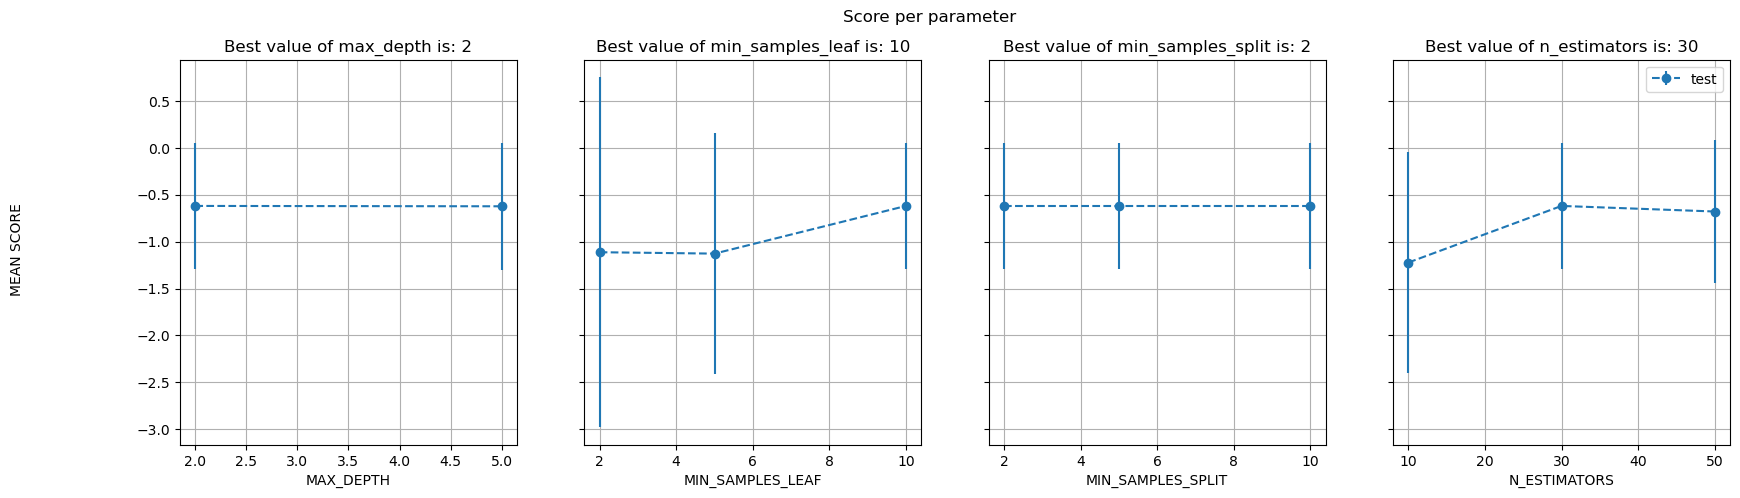

In [18]:
#Trying the plot function

import importlib
import rf_plot 

importlib.reload(rf_plot)  # Reload the module
from rf_plot import plot_gsearch_results

plot_gsearch_results(rf_trained)

In [105]:
X

Variables      bm                                                         \
Years        2005    2006    2007    2008   2009    2010    2011    2012   
Glaciers                                                                   
2.0         -1.44    2.65    0.84    4.95   1.99    0.10    0.51    0.54   
4.0          0.90   -0.59    0.30   -1.26   1.10    0.02    0.13   -0.01   
6.0          8.34   28.99   22.62    9.70  12.23   13.68   12.04   35.70   
7.0          0.00   -0.35    0.23    0.62   0.72    0.26    0.80   -0.29   
8.0         35.82   99.49   70.63   81.18 -30.39    6.77  -13.11   32.74   
15.0         9.96    4.51  -11.27  -10.05   4.01   -2.88   -0.25    0.38   
18.0         0.08   -0.02   -0.01   -0.03   0.00    0.04   -0.01    0.05   
16.0         4.78    0.52    5.38    0.60   5.42    5.28    2.62    3.83   
34.0      -152.96  -76.76  180.17  259.57 -11.38  152.50   14.50  104.90   
45.0        75.37   68.13   91.96   44.14  93.57  101.10   45.86   83.34   
135.0        1.60   -0.90   -1.01    0.68  -0.33   -0.28    0.09    0.08   
163.0       -0.06    0.50   -0.45    0.08   0.03   -0.31    0.01    0.30   
95.0        -4.23   -3.57    4.07    3.64  -3.00   -2.94   -0.52   -0.98   
3.0          0.03   -0.01    0.03    0.04   0.03   -0.02    0.01    0.02   
29.0         0.32    0.70   -0.18    0.38  -1.07   -0.05   -0.79    0.10   
10.0        11.84   -4.18    9.50    6.72   2.33   -2.37   12.24    6.46   
12.0         4.34    3.79    2.85    2.71   6.51    4.51    4.22    6.73   
31.0         3.95    4.59    1.03    5.77   0.73    2.21    3.54    3.44   
30.0         0.59   -0.30    0.37   -0.20  -0.27   -0.25    0.39    0.19   
19.0        -0.12    0.13    0.32   -0.08   0.58    0.57    0.08    0.42   
24.0         3.66    3.63    4.63    1.40   5.13    2.94    3.46    7.63   
35.0       -59.93    4.67   55.91   89.39 -34.18   37.19   20.23   62.67   
50.0        14.31    7.72   22.71   10.15  57.94   33.91   22.62   13.15   
86.0         0.90    3.72    0.06    5.44   5.64    8.94    4.07    2.77   
104.0        5.90    2.19    2.13  -15.95  21.76    4.35    5.96    1.97   
139.0        0.26   -0.32   -0.49    0.20   0.52    0.22    0.08    0.05   
65.0         5.52   19.71   15.99    8.16   4.49    6.27   13.15   12.23   
43.0        -2.51    0.38    2.72   -1.47  -0.22   -0.51   -0.25   -0.25   
37.0        22.51    4.75    9.72   53.74  -6.82   49.07   23.44   16.12   
17.0         4.18    6.10   -2.29    0.56   2.54    2.41    1.94    0.70   
41.0        -0.91   -0.78    3.67    1.29   0.65   -0.17    0.42    0.83   
32.0        -0.10    0.01   -0.35    0.25  -0.04   -0.18    0.22   -0.01   
38.0         2.45    0.80   -1.03    2.87   0.68    0.54    2.03    1.87   
40.0         0.20    0.16    0.15    0.24   0.23    0.23    0.20    0.19   
36.0         2.71   -4.37   15.58   55.28  -9.96   44.87   33.36  -30.98   
52.0        22.56   21.61   21.84   23.02  17.82   23.14    9.22   29.47   
143.0       -0.26   -0.31    0.32   -0.34   0.05    0.08    0.04    0.11   
146.0       -0.54   -0.36    0.31   -0.04  -0.23    0.56    0.44   -0.19   
125.0       -4.65    8.55   -2.93   12.47 -12.09   -0.94    8.23   -0.97   
69.0         0.15   -0.26   -0.36    0.10  -0.42   -0.12    0.28    0.15   
67.0        -2.72    0.46    2.34   -0.88  -0.25    0.15    0.33   -0.27   
63.0         2.47    0.84   -0.04   -0.98   4.41    4.62    5.33    3.01   
26.0        -1.21   -0.49   -0.98   -1.22  -0.75   -2.18   -2.22    1.21   
46.0         6.31    1.50   -0.07    3.38   1.71   11.88    3.21    6.98   
33.0         0.13   -0.08   -0.15    0.86   1.74   -0.15    0.24   -0.55   
64.0         1.23    5.19    7.15    1.88   2.19   -6.82    4.26    1.76   
44.0        -1.00   -0.02    1.36   -0.45   0.33   -0.23   -0.08   -0.06   
70.0       -33.79   85.69  -57.78   72.92 -24.45  -55.77  -33.18   -7.52   
53.0        14.81   20.49   10.15   17.84  15.82   10.19    4.59   11.83   
123.0        1.40    1.58   -0.93    0.42  -1.46

In [96]:
np.array(X.columns)

array([('bm', '2005'), ('bm', '2006'), ('bm', '2007'), ('bm', '2008'),
       ('bm', '2009'), ('bm', '2010'), ('bm', '2011'), ('bm', '2012'),
       ('bm', '2013'), ('bm', '2014'), ('bm', '2015'), ('bm', '2016'),
       ('i_c', '2005'), ('i_c', '2006'), ('i_c', '2007'), ('i_c', '2008'),
       ('i_c', '2009'), ('i_c', '2010'), ('i_c', '2011'), ('i_c', '2012'),
       ('i_c', '2013'), ('i_c', '2014'), ('i_c', '2015'), ('i_c', '2016'),
       ('i_v', '2005'), ('i_v', '2006'), ('i_v', '2007'), ('i_v', '2008'),
       ('i_v', '2009'), ('i_v', '2010'), ('i_v', '2011'), ('i_v', '2012'),
       ('i_v', '2013'), ('i_v', '2014'), ('i_v', '2015'), ('i_v', '2016'),
       ('i_t', '2005'), ('i_t', '2006'), ('i_t', '2007'), ('i_t', '2008'),
       ('i_t', '2009'), ('i_t', '2010'), ('i_t', '2011'), ('i_t', '2012'),
       ('i_t', '2013'), ('i_t', '2014'), ('i_t', '2015'), ('i_t', '2016')],
      dtype=object)

' \nresult = permutation_importance(\n    best_model, X_train_s, y_train_s, n_repeats=10, random_state=42, n_jobs=2\n)\nsorted_idx = result.importances_mean.argsort()\nplt.subplot(1, 2, 2)\nplt.boxplot(\n    result.importances[sorted_idx].T,\n    vert=False,\n    labels=np.array(df_train_X_s.columns)[sorted_idx],\n)\nplt.title("Permutation Importance (test set)")\nfig.tight_layout()\nplt.show()\n'

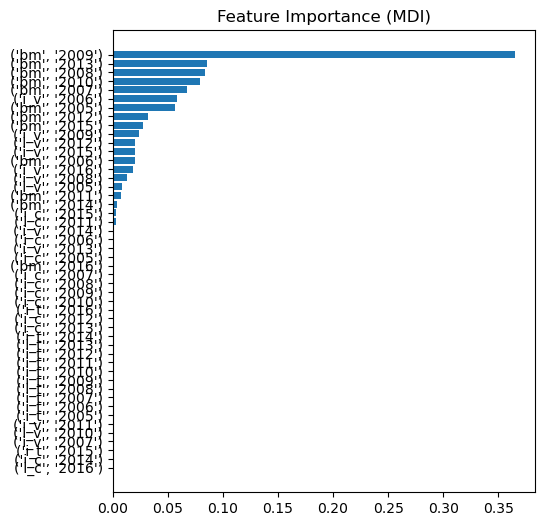

In [83]:
#Experimenting in order to get the feature importance

fitted_rf.fit(X, y)
feature_importance = fitted_rf.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + 0.5
fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align="center")
plt.yticks(pos, np.array(X.columns)[sorted_idx])
plt.title("Feature Importance (MDI)")
''' 
result = permutation_importance(
    best_model, X_train_s, y_train_s, n_repeats=10, random_state=42, n_jobs=2
)
sorted_idx = result.importances_mean.argsort()
plt.subplot(1, 2, 2)
plt.boxplot(
    result.importances[sorted_idx].T,
    vert=False,
    labels=np.array(df_train_X_s.columns)[sorted_idx],
)
plt.title("Permutation Importance (test set)")
fig.tight_layout()
plt.show()
'''

Experimmenting in order to obtain plot_gsearch_results

In [21]:
#Experimmenting in order to obtain plot_gsearch_results

r = RandomForestRegressor(random_state=42, n_jobs=-1)
grid = GridSearchCV(estimator=r, param_grid=grid, cv=cv_split, scoring='neg_mean_squared_error', n_jobs=-1, verbose=0)
grid = grid.fit(X, y)


In [70]:
    ## Results from grid search
results = grid.cv_results_
means_test = results['mean_test_score'] # the mean of the test score for each run
stds_test = results['std_test_score']
#means_train = results['mean_train_score']
#stds_train = results['std_train_score']

In [26]:
results['param_max_depth'].data

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5], dtype=object)

In [28]:
means_test

array([-2179.42425447, -1989.12293571, -1914.49417856, -2179.42425447,
       -1987.01862236, -1911.8368941 , -2179.42425447, -1986.38472041,
       -1911.49402622, -1979.64867044, -1859.30202234, -1866.72323389,
       -1979.64867044, -1859.30202234, -1866.72323389, -1979.64867044,
       -1859.30202234, -1866.72323389, -1861.52478666, -1783.53023808,
       -1783.48837082, -1861.52478666, -1783.53023808, -1783.48837082,
       -1861.52478666, -1783.53023808, -1783.48837082, -2193.6125729 ,
       -2012.00440667, -1934.24782205, -2196.49954042, -2001.46235307,
       -1922.43783669, -2183.09688244, -1996.88965871, -1919.18372968,
       -1975.41856894, -1856.97139012, -1865.23711434, -1975.41856894,
       -1856.97139012, -1865.23711434, -1975.41856894, -1856.97139012,
       -1865.23711434, -1862.76214427, -1784.84134216, -1784.42453592,
       -1862.76214427, -1784.84134216, -1784.42453592, -1862.76214427,
       -1784.84134216, -1784.42453592])

In [29]:
masks = []
masks_names = list(grid.best_params_.keys()) #grid.best_params_.keys() is a dict_keys object. It includes the name of all the parameters that i have used in the grid search

for p_k, p_v in grid.best_params_.items(): #Here we are iterating in parallel over the best criterion and its corresponding value
    print(p_k, p_v)
    masks.append(list(results['param_' + p_k].data == p_v)) #When the parameter is equal to its best value, the mask is True, otherwise is False

max_depth 2
min_samples_leaf 10
min_samples_split 2
n_estimators 50


In [71]:
np.shape(masks)

(4, 54)

In [30]:
params=grid.param_grid #Sono i parametri della griglia
width = len(grid.best_params_.keys())*5
width

20

In [59]:
prova = np.array([[True, False, True],
                  [True, True, False],
                  [True, True, True]])

test = prova.all(axis=0)
test

array([ True, False, False])

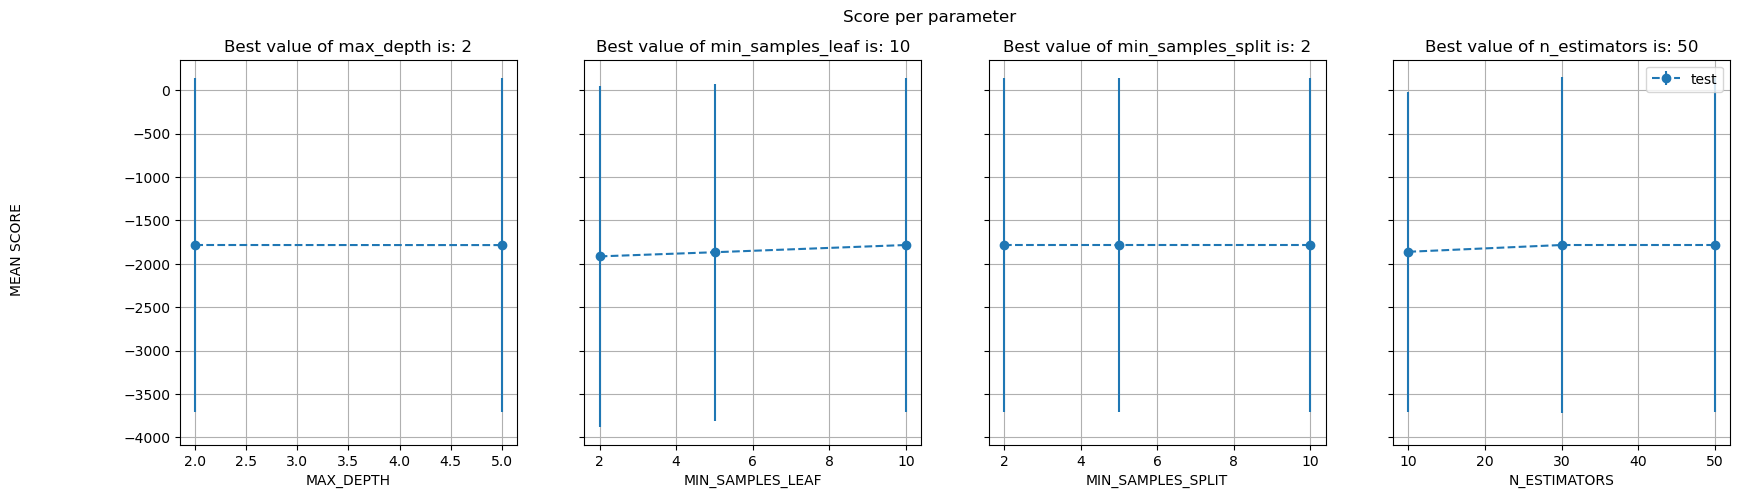

In [60]:
#Plotting the results
fig, ax = plt.subplots(1,len(params),sharex='none', sharey='all',figsize=(width,5))
fig.suptitle('Score per parameter')
fig.text(0.04, 0.5, 'MEAN SCORE', va='center', rotation='vertical')
pram_preformace_in_best = {}

for i, p in enumerate(masks_names): #i is the index of the parameter, p is the name of the parameter
        m = np.stack(masks[:i] + masks[i+1:]) #here i select all the masks except the one of the parameter that i am plotting
        best_parms_mask = m.all(axis=0) # Here I check when ALL the other parameters are equal to their best value (looking at columns, when all the values in column are true)
        best_index = np.where(best_parms_mask)[0]
        x = np.array(params[p])
        y_1 = np.array(means_test[best_index])
        e_1 = np.array(stds_test[best_index])
        #y_2 = np.array(means_train[best_index])
        #e_2 = np.array(stds_train[best_index]
        ax[i].errorbar(x, y_1, e_1, linestyle='--', marker='o', label='test')
        #ax[i].errorbar(x, y_2, e_2, linestyle='-', marker='^',label='train' )
        ax[i].set_xlabel(p.upper())
        ax[i].grid()

        #Set the title of the plot
        title = 'Best value of ' + p + ' is: ' + str(grid.best_params_[p])
        ax[i].set_title(title)
        

plt.legend()
plt.show()

In [ ]:
import importlib
import rf_plot

importlib.reload(rf_plot)  # Reload the module
from rf_functions import plot_gsearch_results


In the next code block i will perform a Grisd-search and a model tuning accorrding to the block division strategy. The order of the blocks is preserved by Kfold, by not mixing the variables. This was re done with the functions later (blocks above)

In [61]:
''' 
#defining the grid for the search
grid = {
    'n_estimators': [10, 50, 100, 500, 1000],
    'max_depth': [5,10,15,20,25,30,35,40,45,50],
    'min_samples_split': [1, 2, 3, 5, 10, 15, 20],
    'min_samples_leaf': [1, 2, 3, 5],
    'criterion': ['squared_error'],
}

#defining the model
rf = sklearn.ensemble.RandomForestRegressor(random_state=42, n_jobs=-1)

#Splitting the dataset in 8 blocks, according to the folders division. The shuffle is set to False, in order to have the same division as the one i used for the folders
cv_split = KFold(n_splits=8, shuffle=False, random_state=None)


#Perform the grid search
grid_search = GridSearchCV(estimator=rf, param_grid=grid, cv=cv_split, verbose=2, n_jobs=-1, scoring='neg_mean_squared_error') #lower values are better


#Fitting the model
grid_search.fit(cv.drop(['calving'], axis=1), cv['calving'])


print(grid_search.best_params_)
print(grid_search.best_score_)
'''

Fitting 8 folds for each of 1400 candidates, totalling 11200 fits
[CV] END criterion=squared_error, max_depth=5, min_samples_leaf=1, min_samples_split=1, n_estimators=10; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, min_samples_leaf=1, min_samples_split=1, n_estimators=10; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, min_samples_leaf=1, min_samples_split=1, n_estimators=10; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, min_samples_leaf=1, min_samples_split=1, n_estimators=10; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, min_samples_leaf=1, min_samples_split=1, n_estimators=10; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, min_samples_leaf=1, min_samples_split=1, n_estimators=10; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, min_samples_leaf=1, min_samples_split=1, n_estimators=10; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, min_samples_leaf=1,

KeyboardInterrupt: 

In the next cell i will keep records of the results


In [62]:
grid = {
    'n_estimators': [10, 50, 100, 500, 1000],
    'max_depth': [5,10,15,20,25,30,35,40,45,50],
    'min_samples_split': [1, 2, 3, 5, 10, 15, 20],
    'min_samples_leaf': [1, 2, 3, 5],
    'criterion': ['squared_error'],
}

{'criterion': 'squared_error', 'max_depth': 5, 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 500}
-1750.2160949671716

-1750.2160949671716

In [13]:

from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold

cv_split = KFold(n_splits=8, shuffle=False, random_state=None)
rf_fitted = sklearn.ensemble.RandomForestRegressor(criterion='squared_error', 
                                                   max_depth= 5,#grid_search.best_params_['max_depth'], 
                                                   n_estimators=  500,#grid_search.best_params_['n_estimators'],
                                                   min_samples_split= 10,# grid_search.best_params_['min_samples_split'],
                                                   min_samples_leaf= 5,#grid_search.best_params_['min_samples_leaf'],
                                                   random_state=42,
                                                   n_jobs=-1
                                                   )

cvs = cross_val_score(rf_fitted, cv.drop(['calving'], axis=1), cv['calving'], cv=cv_split, scoring='neg_mean_squared_error', n_jobs=-1)

rf_fitted.fit(cv.drop(['calving'], axis=1), cv['calving'])

RandomForestRegressor(max_depth=5, min_samples_leaf=5, min_samples_split=10,
                      n_estimators=500, n_jobs=-1, random_state=42)

In [14]:
print('Cross validation scores per fold: ', cvs)
print('Mean cross validation score: ', cvs.mean())
print('Standard deviation: ', cvs.std())

#plot_prediction_per_fold(X, y, fitted_model, idc_list)

Cross validation scores per fold:  [-2136.27726829  -872.4052544   -107.72849283  -492.92853494
 -1657.13642556 -6523.02859944  -129.31307003 -2082.91111425]
Mean cross validation score:  -1750.2160949671718
Standard deviation:  1959.7368526462917


Cross validation scores per fold:  [-2277.51726151  -958.2659416   -142.88396257  -764.34435281
 -1769.59631356 -6455.15156281  -110.56429227 -2180.08198158]
Mean cross validation score:  -1832.3007085891043
Standard deviation:  1917.5773855003897

In [14]:
#len(rf_fitted.predict(cv.drop('calving', axis=1)))
len(cv['calving'])

104

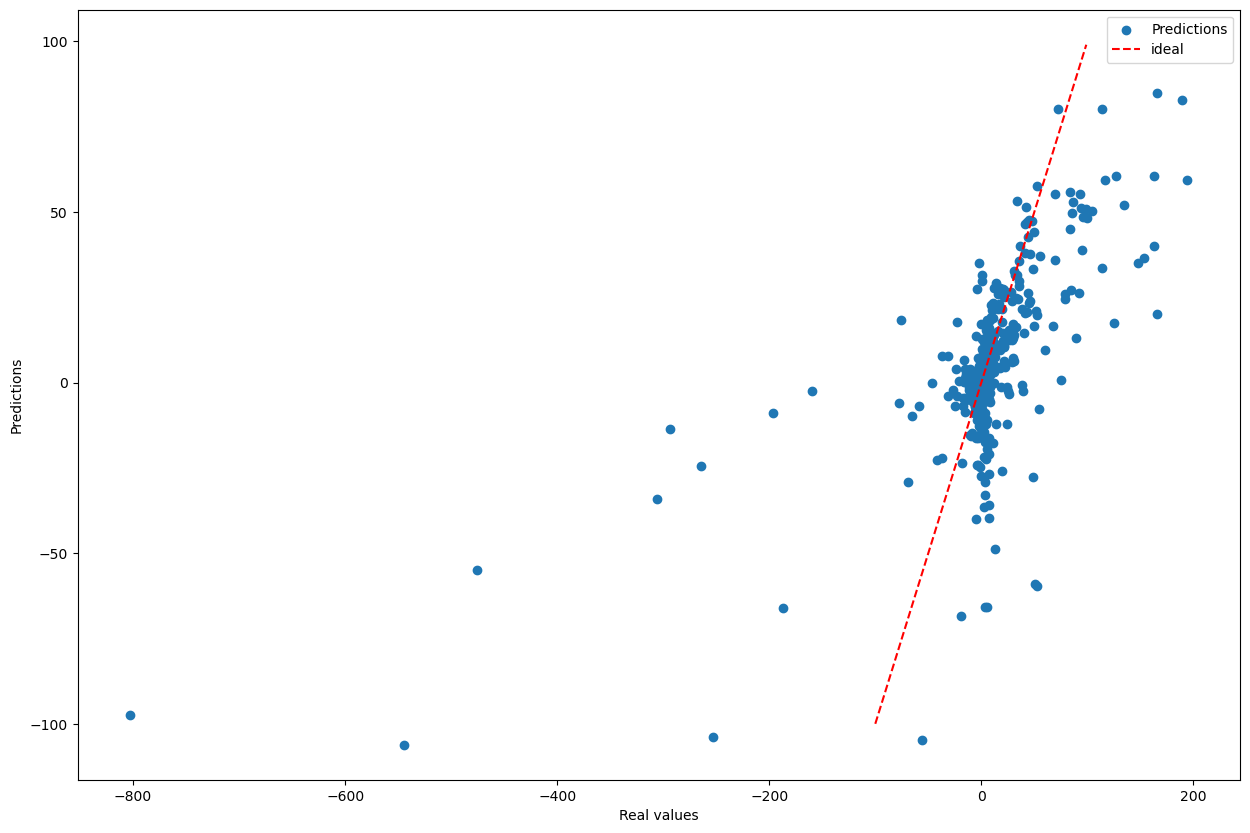

In [15]:
#Plot the predictions against the real values
plt.figure(figsize=(15,10))
plt.scatter(cv['calving'], rf_fitted.predict(cv.drop('calving', axis=1)), label='Predictions')

#labels
plt.xlabel('Real values')
plt.ylabel('Predictions')

#Plot the 1:1 line
plt.plot(np.arange(-100,100), np.arange(-100,100), label='ideal', color='red', linestyle='--')

#Limit the axis
#plt.xlim(-100, 100)
#plt.ylim(-100, 100)


plt.legend()

Experimenting with functions

type: Number of dimensions is greater than number of samples. This results in a singular data covariance matrix, which cannot be treated using the algorithms implemented in `gaussian_kde`. Note that `gaussian_kde` interprets each *column* of `dataset` to be a point; consider transposing the input to `dataset`.

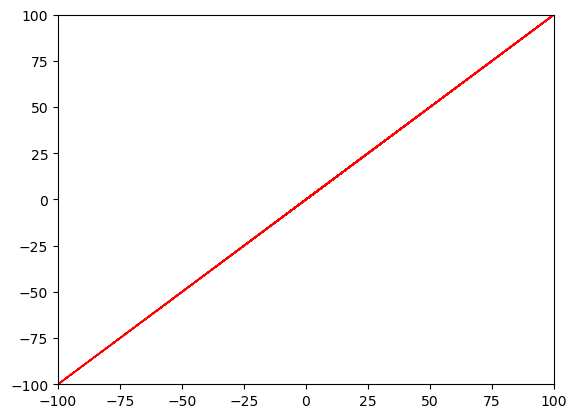

In [16]:
from scipy.stats import gaussian_kde

#plot also the line of the perfect prediction
plt.plot(cv['calving'], cv['calving'], color='red', linewidth=1, linestyle='--')

#Limit the axis to -100, 100
plt.xlim(-100, 100)
plt.ylim(-100, 100)

x = cv['calving']
y = rf_fitted.predict(cv.drop('calving', axis=1))

xy = np.vstack([x,y])

z = gaussian_kde(xy)(xy)

fig, ax = plt.subplots()
ax.scatter(x, y, c=z, s=100, cmap='viridis')
plt.show()


#cbar = plt.colorbar()
#cbar.set_label('Point Density')

plt.show()



In [ ]:
def plot_prediction_per_fold(X, y, model, idc_list):
    """
    Plot model predictions of model vs. test data y based on 
    folds given by indices X_idc and y_idc.
  
    Parameters:
    X : np.array
        Training dataset of features.
    y : np.array
        Labels of training dataset.
    model : sklearn.model
        Fitted XGBmodel object.
    X_idc : np.array
        Indices of fold splits of features.
    y_idc : np.array
        Indices of fold splits for labels.
    """

    y_test_list = []
    y_pred_list = []

    for train_index, test_index in idc_list:
        # Loops over n_splits iterations and gets train and test splits in each fold
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        y_test_list.extend(y_test)
        y_pred_list.extend(y_pred)

    # Arrays of predictions and observations for each fold
    y_test_all = np.hstack([*y_test_list])
    y_pred_all = np.hstack([*y_pred_list])

    # Plot predictions and observations for each cross-valiadation fold together
    plot_prediction(y_test_all, y_pred_all, 'Validation', n_toplot=5000)


In the following block i performed (twice) a Random forest grid search, looking for the best hyper-parameters. I did it 'manually', i will now try to re do it with the 
cross validation which is included in the function (previous code blocks)

In [ ]:
# operate cross validation with the block method
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

#Grid search
'''
grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None,2, 5, 10, 20],
    'criterion': ['squared_error', 'absolute_error']
}
'''
grid = {
    'n_estimators': [10,50,100],
    'max_depth': [None,1],
    'criterion': ['squared_error', 'absolute_error']
}

#rf = RandomForestRegressor(n_estimators=1000, random_state=42)
best_parameters = []
mae_scores = []

for i in range(len(cv_blocks)):
    print(f"Fold {i +1 }:")

    #Extracting the training an testing blocks from the list
    validation_block = cv_blocks[i]
    train_blocks = cv_blocks[:i] + cv_blocks[i+1:]

    #Extracting the training and testing variables and targets
    X_test = validation_block.drop(['calving'], axis=1)
    y_test = validation_block['calving']

    X_train = pd.concat(train_blocks).drop(['calving'], axis=1)
    y_train = pd.concat(train_blocks)['calving']

    # Fit the model on the training data
    rf_cv = GridSearchCV(RandomForestRegressor(), grid)

    # Make predictions on the test data
    rf_cv.fit(X_train, y_train)
    y_pred = rf_cv.predict(X_test)

    '''
    plt.scatter(y_test, y_pred)
    plt.xlabel('True Values')
    plt.ylabel('Predictions')

    #plot the line y= x (diagonal of the first and third quadrant)
    max_value = np.max([y_test, y_pred])
    min_value = np.min([y_test, y_pred])
    x = np.linspace(min_value, max_value, 100)
    plt.plot(x, x, color='black')
    plt.title('Fold ' + str(i+1))


    plt.show()
    '''

    # Evaluate the model's performance
    mae = mean_absolute_error(y_test, y_pred)
    mae_scores.append(mae)

    best_parameters.append(rf_cv.best_params_)



Fold 1:


KeyboardInterrupt: 

In [ ]:
mae_scores

[14.941517628205128,
 9.198303205128205,
 3.3142384615384617,
 8.581923076923077,
 13.542544871794872,
 15.390641987179487,
 5.062366666666667,
 10.802583333333333]

In [ ]:
best_parameters

[{'criterion': 'absolute_error', 'max_depth': 1, 'n_estimators': 100},
 {'criterion': 'absolute_error', 'max_depth': 1, 'n_estimators': 100},
 {'criterion': 'absolute_error', 'max_depth': 1, 'n_estimators': 50},
 {'criterion': 'absolute_error', 'max_depth': 1, 'n_estimators': 10},
 {'criterion': 'absolute_error', 'max_depth': 1, 'n_estimators': 10},
 {'criterion': 'absolute_error', 'max_depth': 1, 'n_estimators': 100},
 {'criterion': 'absolute_error', 'max_depth': 1, 'n_estimators': 50},
 {'criterion': 'absolute_error', 'max_depth': 1, 'n_estimators': 10}]

In the following block i saved the results fromm the grid search

In [ ]:
#First grid search
grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None,2, 5, 10, 20],
    'criterion': ['squared_error', 'absolute_error']
}


#Mae scores
scores_1 = [13.543539246872902,
 7.1936,
 3.0449211538461536,
 7.448460042735043,
 16.490779807692306,
 15.644852350427351,
 5.029717307692307,
 11.763670210811362]


[{'criterion': 'squared_error', 'max_depth': 20, 'n_estimators': 100},
 {'criterion': 'absolute_error', 'max_depth': 2, 'n_estimators': 100},
 {'criterion': 'absolute_error', 'max_depth': 2, 'n_estimators': 100},
 {'criterion': 'absolute_error', 'max_depth': 2, 'n_estimators': 300},
 {'criterion': 'absolute_error', 'max_depth': 2, 'n_estimators': 100},
 {'criterion': 'absolute_error', 'max_depth': 2, 'n_estimators': 300},
 {'criterion': 'absolute_error', 'max_depth': 2, 'n_estimators': 100},
 {'criterion': 'squared_error', 'max_depth': 5, 'n_estimators': 100}]

#Second grid search
grid = {
    'n_estimators': [10,50,100],
    'max_depth': [1,2,5],
    'criterion': ['squared_error', 'absolute_error']
}

#Mae scores

scores_2 = [13.75309294871795,
 8.036669551282051,
 3.2670608974358974,
 10.98667982493302,
 14.47870608974359,
 15.34166474358974,
 4.937871794871795,
 11.16877564102564]

[{'criterion': 'absolute_error', 'max_depth': 1, 'n_estimators': 10},
 {'criterion': 'absolute_error', 'max_depth': 1, 'n_estimators': 100},
 {'criterion': 'absolute_error', 'max_depth': 1, 'n_estimators': 50},
 {'criterion': 'squared_error', 'max_depth': 1, 'n_estimators': 10},
 {'criterion': 'absolute_error', 'max_depth': 1, 'n_estimators': 100},
 {'criterion': 'absolute_error', 'max_depth': 1, 'n_estimators': 100},
 {'criterion': 'absolute_error', 'max_depth': 1, 'n_estimators': 10},
 {'criterion': 'absolute_error', 'max_depth': 1, 'n_estimators': 10}]

[{'criterion': 'absolute_error', 'max_depth': 1, 'n_estimators': 10},
 {'criterion': 'absolute_error', 'max_depth': 1, 'n_estimators': 100},
 {'criterion': 'absolute_error', 'max_depth': 1, 'n_estimators': 50},
 {'criterion': 'squared_error', 'max_depth': 1, 'n_estimators': 10},
 {'criterion': 'absolute_error', 'max_depth': 1, 'n_estimators': 100},
 {'criterion': 'absolute_error', 'max_depth': 1, 'n_estimators': 100},
 {'criterion': 'absolute_error', 'max_depth': 1, 'n_estimators': 10},
 {'criterion': 'absolute_error', 'max_depth': 1, 'n_estimators': 10}]

In [ ]:
#Here i will use the best parameters found in the grid search to train the model on the entire dataset.
# I will use the weights to give more importance to the glaciers with a lower mae score

#Scores
weights_1 = [1/score for score in scores_1]
weights_2 = [1/score for score in scores_2]
weights_list = weights_1 + weights_2

#n_estimator
n_estimmator_list = [100, 100, 100, 300, 100, 300, 100, 100, 10, 100, 50, 10, 100, 100, 10, 10]
n_estimator_weighted_avg = np.average(n_estimmator_list, weights=weights_list)

#max_depth
max_depth_list = [20, 2, 2, 2, 2, 2, 2, 5, 1, 1, 1, 1, 1, 1, 1, 1]
max_depth_weighted_avg = np.average(max_depth_list, weights=weights_list)


In [ ]:
#Perform random forest with the best parameters on the whole dataset

train_block = cv_blocks

test_block = dataset.loc[test]


#Extracting the training and testing variables and targets
X_test = test_block.drop(['calving'], axis=1)
y_test = test_block['calving']

X_train = pd.concat(train_blocks).drop(['calving'], axis=1)
y_train = pd.concat(train_blocks)['calving']


In [ ]:
#Perform random forest with the best parameters on the whole dataset

rf_optimized = RandomForestRegressor(n_estimators= int(n_estimator_weighted_avg), max_depth=int(max_depth_weighted_avg), criterion='absolute_error', random_state=42)
rf_optimized.fit(X_train, y_train)

RandomForestRegressor(criterion='absolute_error', max_depth=2, n_estimators=92,
                      random_state=42)

In [ ]:
# Make predictions on the test data
y_pred = rf_optimized.predict(X_test)

# Evaluate the model's performance
mae = mean_absolute_error(y_test, y_pred)
mae

3.3510275135869567